# Dempster-Shafer Inference Algorithm

In [1]:
from config import *
from DS import DempsterShafer
from process_data import DataProcessor
from datetime import datetime
import os
import time
import pandas as pd
import numpy as np


## Download data

In [2]:

csv_file_dir = "data/20240408/raw"
csv_file_pattern = "20240408_UTS{}.csv"  # Replace with the pattern for your file names
data_processor = DataProcessor(csv_file_dir, csv_file_pattern, selected_headers)
csv_data = data_processor.process_files(start=1, end=5)


## Process data

### Sampling data

#### Resample data

In [3]:
#
filename_pattern = "20240408_UTS{}"
data_process_day = datetime(2024, 4, 7)
resampled_data = {}
# Loop through all sensors to process their raw csv data
for sensor_order in range(1, num_sensors + 1):
    filename = filename_pattern.format(sensor_order)
    combined_data = csv_data[filename]
    # print("Combined Data", (combined_data))
    # Convert the 'UTCDateTime' column to datetime format
    combined_data['date_time_utc'] = pd.to_datetime(combined_data['date_time_utc'])

    # Set 'UTCDateTime' as the index
    combined_data.set_index('date_time_utc', inplace=True)

    # Resample data to 2-minute frequency
    resampled_values = combined_data[parameter_headers].resample('2min').bfill(limit=1).round(3).fillna(0)
    # print("Resampled Values", resampled_values)
    # print(combined_data.drop(parameter_headers,axis=1))
    concat_data = pd.concat([combined_data.drop(parameter_headers,axis=1).resample('2min').bfill(), resampled_values], axis=1)

    # Backward fill other columns
    resampled_data[filename] = concat_data
    output_folder = os.path.join("data", data_process_day.strftime("%Y%m%d"), "processed")
    os.makedirs(output_folder, exist_ok=True)
    resampled_data[filename].to_csv(os.path.join(output_folder, f"{filename}"))

    
# print("Indexes", indexes)
# print("\nA", resampled_data)
# prepared_data = {key[:-4]: resampled_data[key][parameter_headers].values for key in resampled_data}


#### Sampling data

In [4]:
start_time_sampling = convert_to_unix("08-04-2024 02:30:00")
end_time_sampling = convert_to_unix("08-04-2024 03:30:00")
sampling_data = {}

for key, value in resampled_data.items():
    sampling_data[key] = value[parameter_headers][
        (value[time_header] > start_time_sampling)
        & (value[time_header] < end_time_sampling)
    ]

# print("Sampling Data", sampling_data)
first_key = list(sampling_data.keys())[0]
first_value = sampling_data[first_key]
indexes = first_value.index
# print("Indexes", indexes)


### Feature matrix

#### Normal operation

In [5]:
start_time_feat_normal = "08-04-2024 00:00:00"
end_time_feat_normal = "08-04-2024 01:00:00"
normal_operation_data = {}
for key, value in resampled_data.items():
    normal_operation_data[key] = value[parameter_headers][
        (value[time_header] > convert_to_unix(start_time_feat_normal))
        & (value[time_header] < convert_to_unix(end_time_feat_normal))
    ]
    # print(normal_operation_data)
mean_normal_operation_data = {
    key: value.mean(axis=0).to_frame().T for key, value in normal_operation_data.items()
}

# Concatenate all DataFrames into a single DataFrame
concatenated_df = pd.DataFrame()
for key, value in mean_normal_operation_data.items():
    concatenated_df = pd.concat([concatenated_df, value], ignore_index=True)
# print("Concatenated Data", concatenated_df)
# Compute the mean for each column
mean_concatenated_df = concatenated_df.mean()
# print(mean_concatenated_df)
feat_mat_normal = mean_concatenated_df.to_numpy()
print("Feature Matrix Normal", feat_mat_normal)

Feature Matrix Normal [43.         88.87083333  2.87879167  2.435       4.00979167]


#### Faulty operation

In [6]:


start_time_feat_fault = "08-04-2024 01:30:00"
end_time_feat_fault = "08-04-2024 02:00:00"
fault_operation_data = {}
for key, value in resampled_data.items():
    fault_operation_data[key] = value[parameter_headers][
        (value[time_header] > convert_to_unix(start_time_feat_fault))
        & (value[time_header] < convert_to_unix(end_time_feat_fault))
    ]
    # print(fault_operation_data)
first_key = list(fault_operation_data.keys())[0]
first_value = fault_operation_data[first_key]
print("First Value", first_value)
average_value = first_value.mean(axis=0).to_numpy()

feat_mat_fault_heat = average_value
print("Feature Matrix Fault", feat_mat_fault_heat)


First Value                            humidity  temperature  pm1.0_atm  pm2.5_alt  \
date_time_utc                                                            
2024-04-07 15:30:00+00:00      28.0        104.0      0.910        1.6   
2024-04-07 15:32:00+00:00      26.5        106.0      1.305        1.6   
2024-04-07 15:34:00+00:00      25.0        107.0      0.625        1.4   
2024-04-07 15:36:00+00:00      25.0        108.0      0.690        1.4   
2024-04-07 15:38:00+00:00      24.0        109.0      0.985        1.5   
2024-04-07 15:40:00+00:00      23.0        110.0      0.975        1.4   
2024-04-07 15:42:00+00:00      22.5        111.0      0.675        1.3   
2024-04-07 15:44:00+00:00      22.0        112.0      0.525        1.4   
2024-04-07 15:46:00+00:00      21.5        112.5      0.420        1.4   
2024-04-07 15:48:00+00:00      21.0        113.0      0.285        1.4   
2024-04-07 15:50:00+00:00      22.0        111.0      0.415        1.2   
2024-04-07 15:52:00+00:00 

In [7]:
# Loss of communication
feat_mat_fault_com = np.zeros((1, len(parameter_headers)))


### Final feature matrix

In [8]:
feat_mat = np.vstack(
    [
        feat_mat_normal,
        feat_mat_fault_heat,
        # feat_mat_fault_com,
    ]
)
print("Feature matrix: ", feat_mat)
print("Shape of Feature matrix: ", feat_mat.shape[0])

Feature matrix:  [[ 43.          88.87083333   2.87879167   2.435        4.00979167]
 [ 24.83333333 107.36666667   0.68533333   1.36666667   1.217     ]]
Shape of Feature matrix:  2


## DSI

### Initialization

In [9]:


DSI_hypotheses = [
    hypotheses["Normal"]["Average Normal"],
    hypotheses["Overheat"]["Overheat"],
    hypotheses["Uncertain"]
]

sampling_freq = [1]
print(DSI_hypotheses)


['N0', 'F_H', 'F_X']


### Execution

In [10]:
from itertools import islice


DSI_results = {}

for sensor, data in islice(sampling_data.items(), 1):
    # print("AA", sensor)
    # print(data)
    for freq in sampling_freq:
        DSI_results[f"{sensor}_{freq}"] = pd.DataFrame()  # Adjusted to include freq in key
        for i in range(0, len(data), freq):
            if i + freq > len(data):  # Check to avoid index out of range
                break
            sampling_rows = data[i:i+freq]  # Select the desired number of rows based on freq
            # sampling_mat = sampling_rows.reshape((freq, len(parameter_headers)))  # Adjust reshape according to freq
            sampling_mat = sampling_rows.to_numpy()
            print("Sampling Matrix", sampling_mat)
            ds = DempsterShafer(sampling_mat, feat_mat)
            ds.hypothesis_order(DSI_hypotheses)
            reliability = ds.result()
            
            # Concatenate the reliability results for the current freq to its DataFrame
            DSI_results[f"{sensor}_{freq}"] = pd.concat([DSI_results[f"{sensor}_{freq}"], reliability], axis=0, ignore_index=True)

# print("AB", DSI_results['20240316_UTS1'])
first_key = list(DSI_results.keys())[0]
first_value = DSI_results[first_key]
print(first_key, first_value)



Sampling Matrix [[41.5   88.5    2.095  1.8    2.74 ]]
Sampling Matrix [[42.    88.5    1.755  1.7    2.385]]
Sampling Matrix [[41.5  88.5   1.83  1.6   2.12]]
Sampling Matrix [[41.5  88.5   1.46  1.6   2.2 ]]
Sampling Matrix [[42.    88.5    1.705  1.5    2.155]]
Sampling Matrix [[42.    88.5    1.595  1.8    2.11 ]]
Sampling Matrix [[42.    88.5    1.72   1.6    2.115]]
Sampling Matrix [[42.    88.5    1.47   1.7    2.185]]
Sampling Matrix [[38.5   93.     0.82   1.6    1.635]]
Sampling Matrix [[0. 0. 0. 0. 0.]]
Sampling Matrix [[34.5   96.     0.725  1.4    1.275]]
Sampling Matrix [[32.    99.     0.945  1.5    1.395]]
Sampling Matrix [[ 30.    101.      0.74    1.4     1.175]]
Sampling Matrix [[ 28.    103.      0.765   1.4     1.22 ]]
Sampling Matrix [[ 27.    104.      0.67    1.3     1.075]]
Sampling Matrix [[ 25.5   106.      0.495   1.4     1.195]]
Sampling Matrix [[ 24.    108.      0.515   1.3     0.945]]
Sampling Matrix [[ 23.    109.5     0.66    1.4     1.125]]
Sampling M

# Result visualization

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from utilities.plot_functions import *


## Prepare result

In [12]:


# Prepare data for normal operation reliability plot
# reliability_comparison = pd.DataFrame() 
# print(reliability_comparison)
# for i, (sensor, data) in enumerate(DSI_results.items()):
#     print("AA", sensor)
#     reliability_comparison = pd.concat([reliability_comparison, data.iloc[:, 0]], axis=1)
#     reliability_comparison = reliability_comparison.rename(columns={reliability_comparison.columns[-1]: f'S{i+1}'})

# reliability_comparison = reliability_comparison.set_index(indexes[0])
# reliability_comparison['Highest Reliability'] = reliability_comparison.idxmax(axis=1)
# print(reliability_comparison)


## Reliability probability

### Initialization

In [13]:


sensor_colors = {"S1": "blue", "S2": "orange", "S3": "green", "S4": "red"}
# Define a color palette with 7 colors
colors = sns.color_palette("Spectral", n_colors=7)


#### Stacked plot for probability assignment

20240408_UTS1_1
{'20240408_UTS1_1':           N0       F_H       F_X
0   0.569915  0.073536  0.356550
1   0.593200  0.089006  0.317793
2   0.486096  0.104079  0.409825
3   0.465759  0.109259  0.424982
4   0.516559  0.123536  0.359904
5   0.582847  0.092724  0.324430
6   0.536491  0.103386  0.360123
7   0.552328  0.099109  0.348563
8   0.058259  0.131313  0.810429
9   0.018883  0.039612  0.941505
10  0.031363  0.840626  0.128011
11  0.057565  0.310943  0.631491
12  0.021657  0.818802  0.159541
13  0.004855  0.931230  0.063916
14  0.016088  0.575995  0.407917
15  0.007208  0.285218  0.707574
16  0.003730  0.070784  0.925486
17  0.009475  0.321858  0.668667
18  0.007489  0.073598  0.918913
19  0.001525  0.008017  0.990457
20  0.003864  0.021241  0.974895
21  0.000564  0.002769  0.996667
22  0.008074  0.527094  0.464831
23  0.012402  0.143774  0.843823
24  0.024149  0.404113  0.571738
25  0.046823  0.328137  0.625041
26  0.062673  0.401679  0.535648
27  0.075081  0.372685  0.552233
28  0.0

C:\Users\13993807_admin\AppData\Local\Temp\ipykernel_14928\2830787524.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


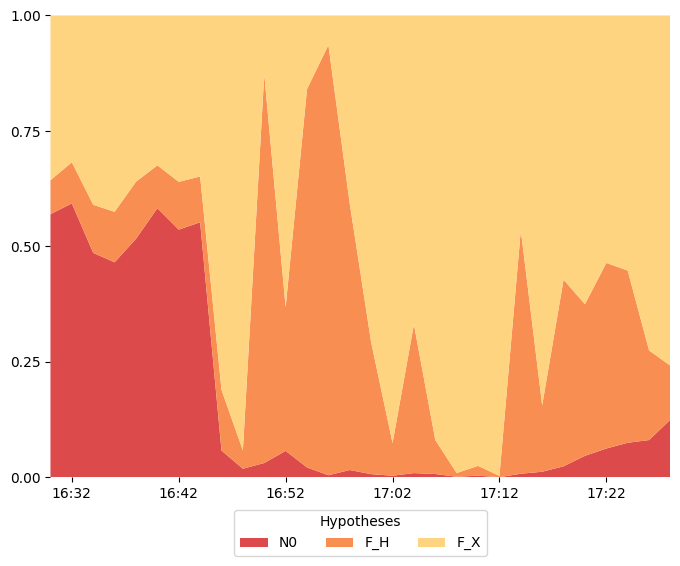

In [15]:
# Create subplots
fig, ax = plot_stacked_area_chart(DSI_results, indexes, colors, time_locator=10)
legend = ax.legend(
    loc="center",
    bbox_to_anchor=(0.5, -0.12),
    title="Hypotheses",
    ncols=len(DSI_hypotheses),
)
# Remove spaces between subplots
# plt.subplots_adjust(hspace=0.2)

# Show the plot
fig.show()
fig.savefig(
    "fig/Faults/Individual/S1/DSI_results_heat.png",
    bbox_extra_artists=(legend,),
    bbox_inches="tight",
)

#### Line graph for normal operation probability

In [17]:

# Prepare data for normal operation reliability plot
reliability_comparison = pd.DataFrame() 
print(reliability_comparison)
for i, (sensor, data) in enumerate(DSI_results.items()):
    print("AA", sensor)
    reliability_comparison = pd.concat([reliability_comparison, data.iloc[:, 0]], axis=1)
    reliability_comparison = reliability_comparison.rename(columns={reliability_comparison.columns[-1]: f'S{i+1}'})

reliability_comparison = reliability_comparison.set_index(indexes[0])
reliability_comparison['Highest Reliability'] = reliability_comparison.idxmax(axis=1)
print(reliability_comparison)


Empty DataFrame
Columns: []
Index: []
AA 20240408_UTS1_1


KeyError: "None of [Timestamp('2024-04-07 16:30:00+0000', tz='UTC')] are in the columns"

In [16]:
# Plot the reliability comparison
fig, ax = plot_line_graph_df(
    reliability_comparison,
    y_columns=reliability_comparison.columns[:-1],
    title="Reliability Comparison",
    xlabel="Time",
    ylabel="Reliability",
    color=list(sensor_colors.values()),
)
# Modify the title using the Axes object
ax.set_title("Probability of normal operation in dependable system")
ax.legend(loc="upper right", ncol=1)
fig.show()
fig.savefig("fig/modified_figure.png")

NameError: name 'reliability_comparison' is not defined

#### Line graph for continuous data flow

In [ ]:
# Prepare data for continuous data flow


In [ ]:


contData = pd.DataFrame()

figContinuos, axContinuos = plot_line_graph_df(
    contData,
    y_columns=contData.columns[:-1],
    title="Reliability Comparison",
    xlabel="Time",
    ylabel="Reliability",
    color=list(sensor_colors.values()),
)
# Modify the title using the Axes object
ax.set_title("Probability of normal operation in dependable system")
ax.legend(loc="upper right", ncol=1)
fig.show()
fig.savefig("fig/DSI_continuous_data.png")

